In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img
from tensorflow.keras.utils import image_dataset_from_directory
import numpy as np
import os
import shutil
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
path = "../dataset_blood_group"

In [47]:
BATCH_SIZE = 32

In [48]:
# Step 1: Loading Dataset
dataset = image_dataset_from_directory(
    path,
    labels="inferred",
    image_size=(64, 64), 
    batch_size=BATCH_SIZE,
    shuffle=True
)

Found 6000 files belonging to 8 classes.


In [4]:
# Step 2: Check class distribution
class_names = dataset.class_names
class_counts = Counter()
for _, labels in dataset.unbatch():
    class_counts[int(labels.numpy())] += 1

print("Class Distribution")
for i, count in class_counts.items():
    print(f"{class_names[i]}: {count}")

Class Distribution
O+: 852
AB-: 761
O-: 712
A-: 1009
AB+: 708
B+: 652
A+: 565
B-: 741


In [50]:
import matplotlib.pyplot as plt
def plot_class_distribution(class_names, class_counts):
    classes = [class_names[i] for i in class_counts.keys()]
    counts = [class_counts[i] for i in class_counts.keys()]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(classes, counts, color=['skyblue', 'lightcoral', 'lightgreen', 'khaki', 'lightpink', 'lightblue', 'grey', 'salmon'])  # Customize colors as needed
    plt.xlabel("Classes")
    plt.ylabel("Number of Images")
    plt.title("Dataset Class Distributon")
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability if needed
    plt.tight_layout() # Adjust layout to prevent labels from overlapping
    plt.show()

    # # Add count labels on top of each bar
    # for bar in bars:
    #     height = bar.get_height()
    #     plt.text(bar.get_x() + bar.get_width()/2, height, str(height), ha='center', va='bottom')  # Centered above bar

    # plt.show()

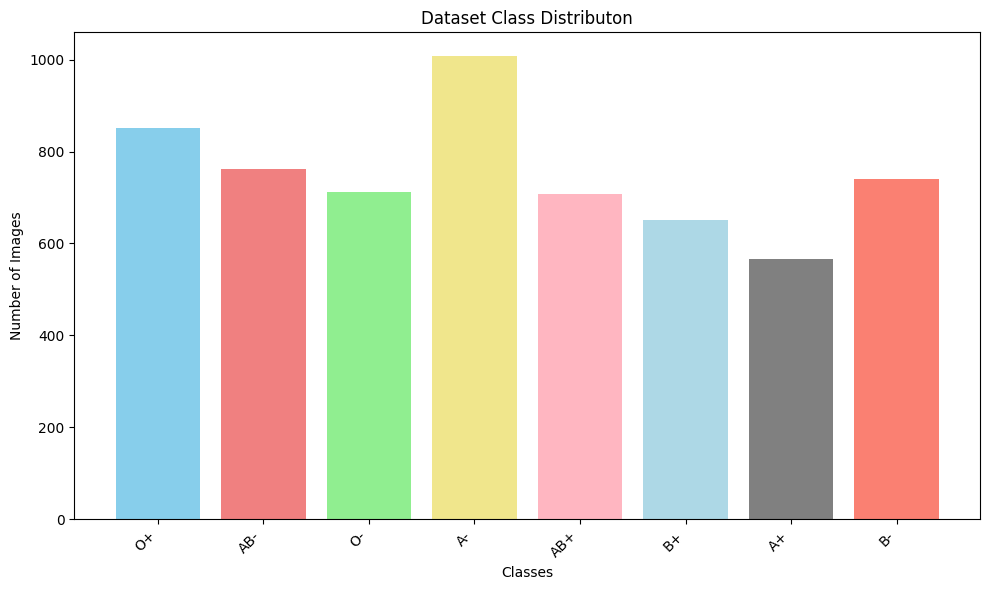

In [51]:
plot_class_distribution(class_names, class_counts)

In [52]:
max_count = max(class_counts.values())
print(max_count)

1009


In [45]:
# Function to oversample a class
def oversample_class(class_id, count, max_count):
    # Ensure the dataset is unbatched for filtering
    unbatched_dataset = dataset.unbatch()

    # Filter the dataset for the specific class
    class_dataset = unbatched_dataset.filter(lambda img, lbl: tf.equal(lbl, class_id))

    # Calculate the number of repetitions needed
    repeat_factor = max_count // count + (max_count % count > 0)

    # Repeat the dataset to match the desired count
    return class_dataset.repeat(repeat_factor).take(max_count)

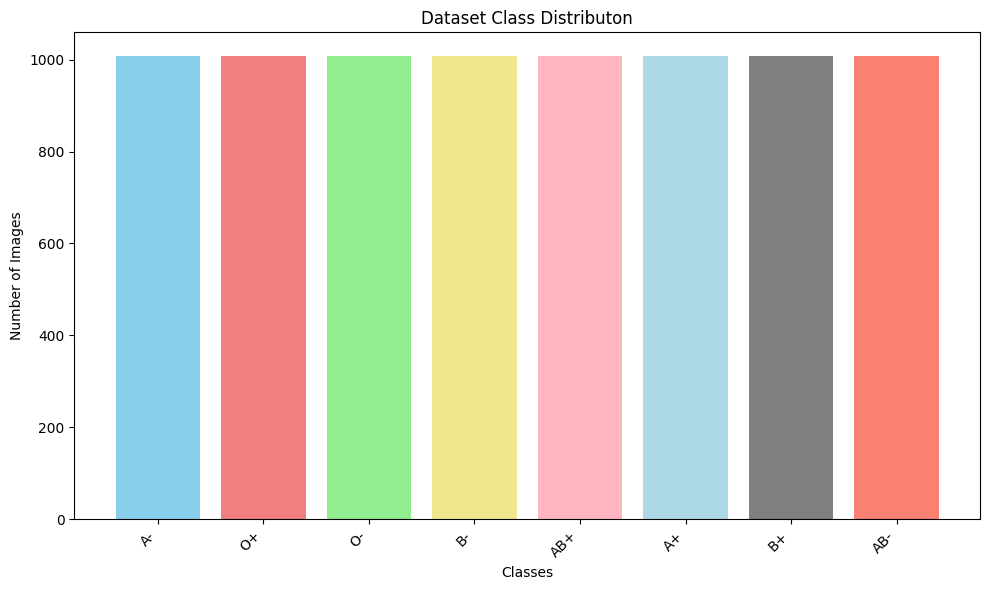

In [53]:
# Balance the dataset
balanced_datasets = []
for class_id, count in class_counts.items():
    balanced_datasets.append(oversample_class(class_id, count, max_count))

# Combine balanced datasets
balanced_datasets = tf.data.Dataset.sample_from_datasets(balanced_datasets)

# Check balanced class distribution
balanced_class_counts = Counter([int(lbl.numpy()) for _, lbl in balanced_datasets])
plot_class_distribution(class_names, balanced_class_counts)

# Batch the balanced dataset
balanced_datasets = balanced_datasets.batch(BATCH_SIZE, drop_remainder=True)

In [55]:
for sample in balanced_datasets.take(10):
    print(sample[0].shape)

(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)


In [57]:
balanced_dataset_unbatched = balanced_datasets.unbatch()
dataset_size = sum(1 for _ in balanced_dataset_unbatched)
print(f"Total dataset size: {dataset_size}")

Total dataset size: 8064


In [60]:
# Define ratios and dataset size
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

In [61]:
# Unbatch the dataset to work at the sample level
balanced_dataset_unbatched = balanced_datasets.unbatch()

# Compute sizes based on dataset size and desired splits
train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)

# Split the dataset into training, validation, and test
train_dataset = balanced_dataset_unbatched.take(train_size)
val_test_dataset = balanced_dataset_unbatched.skip(train_size)
val_dataset = val_test_dataset.take(val_size)
test_dataset = val_test_dataset.skip(val_size)

# Rebatch the datasets after splitting
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

# Check the number of batches in each dataset
train_batch_count = sum(1 for _ in train_dataset)
val_batch_count = sum(1 for _ in val_dataset)
test_batch_count = sum(1 for _ in test_dataset)

print(f"Training dataset size: {train_batch_count * BATCH_SIZE}")
print(f"Validation dataset size: {val_batch_count * BATCH_SIZE}")
print(f"Testing dataset size: {test_batch_count * BATCH_SIZE}")

Training dataset size: 5632
Validation dataset size: 1600
Testing dataset size: 800


In [65]:
def create_high_accuracy_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Dense(len(class_names), activation='softmax')
    ])

    model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
    return model


# Create the model
high_acc_model = create_high_accuracy_model()

c:\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [66]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Define ReduceLROnPlateau callback to reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',             # Monitor validation loss
    factor=0.5,                    # Reduce the learning rate by a factor of 0.5
    patience=3,                    # Wait for 3 epochs without improvement before reducing LR
    verbose=1,                     # Print a message when the learning rate is reduced
    min_lr=1e-6                    # Minimum learning rate to avoid too small values
)

# Define EarlyStopping callback to stop training when validation loss doesn't improve
early_stop = EarlyStopping(
    monitor='val_loss',             # Monitor validation loss
    patience=5,                    # Stop after 5 epochs without improvement
    verbose=1,                     # Print a message when training is stopped
    restore_best_weights=True      # Restore the model weights from the best epoch
)

In [ ]:
# Train the model
history_high_acc = high_acc_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=3,  # Adjust the number of epochs based on your preference -- 50
    callbacks=[reduce_lr, early_stop]
)

Epoch 1/3
    176/Unknown 85s 476ms/step - accuracy: 0.7664 - loss: 0.6220

c:\Python311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


176/176 ━━━━━━━━━━━━━━━━━━━━ 119s 674ms/step - accuracy: 0.7664 - loss: 0.6220 - val_accuracy: 0.8113 - val_loss: 0.7094 - learning_rate: 0.0010
Epoch 2/3
176/176 ━━━━━━━━━━━━━━━━━━━━ 116s 654ms/step - accuracy: 0.7727 - loss: 0.6130 - val_accuracy: 0.7984 - val_loss: 0.6620 - learning_rate: 0.0010
Epoch 3/3
176/176 ━━━━━━━━━━━━━━━━━━━━ 160s 910ms/step - accuracy: 0.7814 - loss: 0.6143 - val_accuracy: 0.7947 - val_loss: 0.7020 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 2.


In [69]:
# Evaluate the model on validation data
high_acc_eval = high_acc_model.evaluate(val_dataset)

print(f"High Accuracy Model - Loss: {high_acc_eval[0]}, Accuracy: {high_acc_eval[1]}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 46s 344ms/step - accuracy: 0.8275 - loss: 0.6496
High Accuracy Model - Loss: 0.6611959338188171, Accuracy: 0.7959558963775635


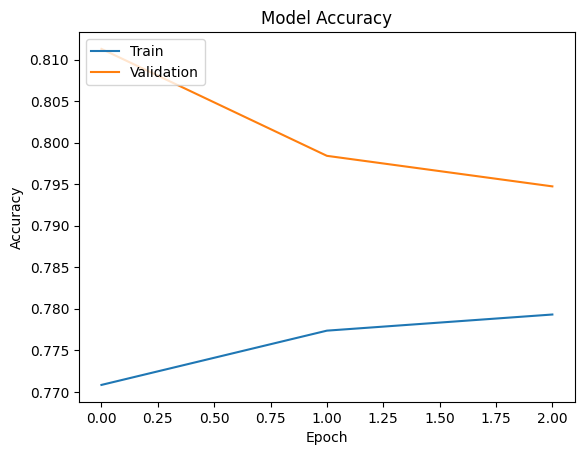

In [70]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')  # Corrected title
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Call the function to display the accuracy graph
plot_accuracy(history_high_acc)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
Classification Report:
  

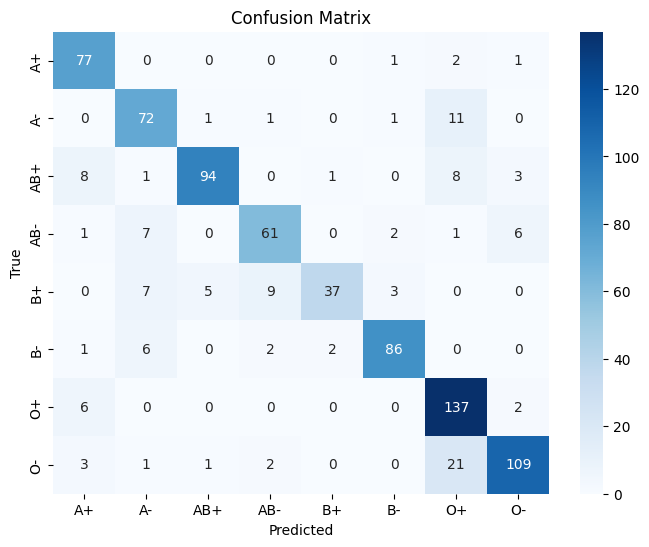

In [71]:
# Get predictions on the test dataset
y_true = []  # True labels
y_pred = []  # Predicted labels

# Iterate over the test dataset and collect the true and predicted labels
for images, labels in test_dataset:
    predictions = high_acc_model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)  # Convert probabilities to class labels
    y_true.extend(labels.numpy())  # Convert tensor to numpy array and append
    y_pred.extend(predicted_labels)  # Append the predicted labels

# Convert to numpy arrays (optional, but often useful)
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Classification report
report = classification_report(y_true, y_pred, target_names=class_names)

print("Classification Report:")
print(report)

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()